In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette()

import sys
sys.path.insert(0, '../..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from circular.training import train_time_periodic
from circular.utils import freq_time, date2rad
from circular.stats import kuiper_two
from circular.plots import base_periodic_fig, plot_CDF_kernel
from circular.circular import kernel

In [4]:
df = pd.read_csv('../../circular/datasets/data/transactions.csv.gz', index_col=0)
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,user,type,amt,date
1,1,1,-0.334,2020-01-01 19:09:57
5,2,1,-0.238,2020-01-01 20:01:43
6,1,1,-0.247,2020-01-02 08:37:52
9,1,2,0.537,2020-01-02 11:16:12
12,1,2,0.537,2020-01-02 11:16:58


In [6]:
df['yyyymm'] = df['date'].dt.year * 100 + df['date'].dt.month

In [7]:
pd.pivot_table(df, index='yyyymm', columns='user', values='amt', aggfunc=len, margins=True)

user,1,2,All
yyyymm,,,
202001,58,30,88
202002,70,29,99
202003,55,27,82
202004,41,20,61
202005,49,24,73
202006,42,31,73
202007,34,19,53
All,349,180,529


In [8]:
train = df.loc[df['yyyymm'] < 202007, ['user', 'date']]
test = df.loc[df['yyyymm'] == 202007, ['user', 'date']]

## Analyze user 1

In [9]:
users = train['user'].unique()
user = users[0]

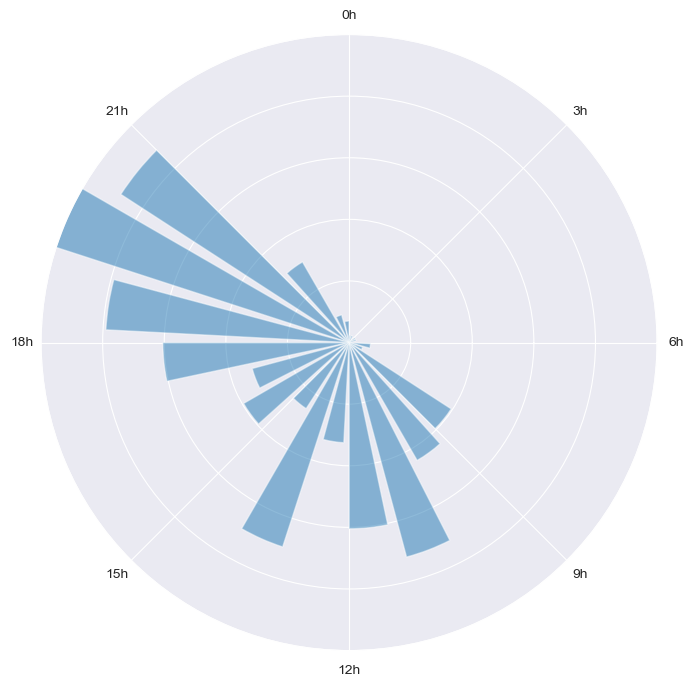

In [10]:
time_segment = 'hour'  # 'hour', 'dayweek', 'daymonth
freq_arr, times = freq_time(df.loc[df['user'] == user, 'date'],time_segment=time_segment)
fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)

# Evaluate the kernel

In [11]:
# The function returns:
#    risks_all : dictionary of shape n_accounts where each value is a
#        pd.DataFrame of shape = [3, n + 1] for each account
#        where the rows are the different time segments ['hour', 'dayweek', 'daymonth']
#        the columns are the n points of the kernel and the confidence of the kernel

risk_all = train_time_periodic(train, idname='user')

### Check the confidence of the estimated kernels

In [12]:
for user in train['user'].unique():
    print('\nAccount number ' + str(user))
    print(risk_all[user]['Risk_confidence'])


Account number 1
hour        0.999202
dayweek     1.000000
daymonth    1.000000
Name: Risk_confidence, dtype: float64

Account number 2
hour        0.999999
dayweek     0.998347
daymonth    1.000000
Name: Risk_confidence, dtype: float64


In [13]:
bw = risk_all[user]['bw'][time_segment]
n = risk_all[user].shape[1] - 2
bw, n

(16.301593922467934, 256)

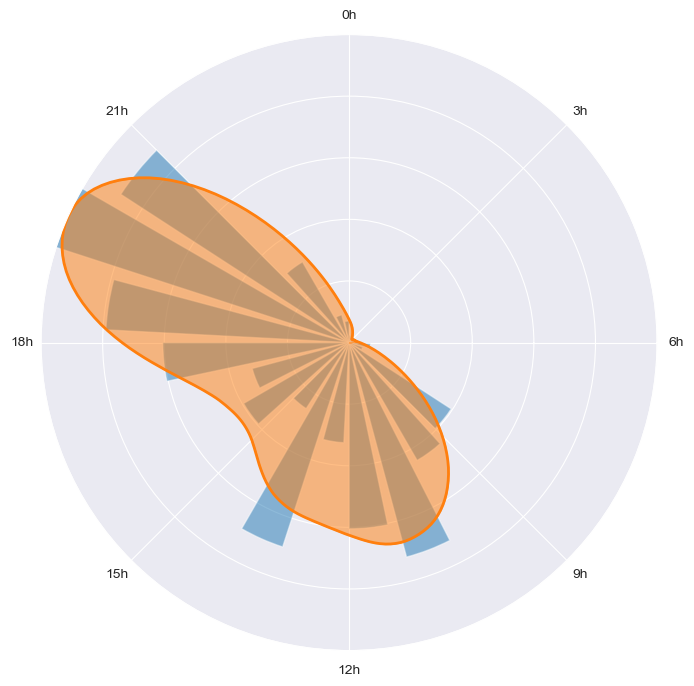

In [14]:
radians = date2rad(times, time_segment='hour')

y = kernel(radians, bw=bw, n=n)
y = y / y.max()
p, (z, d_cdf, k_cdf, D1_, D2_, D1, D2) = kuiper_two(times, y, return_all=True)

fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)

ax1.plot(z + 2*np.pi/30, y, color=current_palette[1], ls='-', linewidth=2)
ax1.fill_between(z + 2*np.pi/30, 0, y, alpha=0.5, color=current_palette[1])